In [25]:
# Load packages
library(DESeq2)
library(tidyverse)
library(ggplot2)
library(pheatmap)

# Load region lengths
region_lengths <- read_tsv("master/shared_consensus_with_ids.hg38.bed", col_names = FALSE) %>%
  setNames(c("chr", "start", "end", "region_id")) %>%
  mutate(length = end - start) %>%
  select(region_id, length)

# === Step 1: Load data ===
load_species <- function(file, species_name, region_lengths) {
  df <- read_tsv(file) %>%
    select(-region) %>%
    left_join(region_lengths, by = "region_id")

  df_counts <- df %>%
    mutate(across(-c(region_id, length), ~ round(. * length))) %>%
    select(-length) %>%
    rename_with(~ paste0(species_name, "_", .), -region_id)

  return(df_counts)
}


bonobo   <- load_species("Bonobo_shared_consensus_quantification.tsv", "Bonobo", region_lengths)
human    <- load_species("Human_shared_consensus_quantification.tsv", "Human", region_lengths)
macaque  <- load_species("Macaque_shared_consensus_quantification.tsv", "Macaque", region_lengths)
marmoset <- load_species("Marmoset_shared_consensus_quantification.tsv", "Marmoset", region_lengths)
chimp <- load_species("Chimpanzee_shared_consensus_quantification.tsv", "Chimpanzee", region_lengths)
gorilla <- load_species("Gorilla_shared_consensus_quantification.tsv", "Gorilla", region_lengths)

# === Step 2: Combine all into one matrix ===
all_data <- list(bonobo, human, macaque, marmoset,chimp,gorilla) %>%
  reduce(inner_join, by = "region_id") %>%
  column_to_rownames("region_id")

# Fill NAs with 0
all_data[is.na(all_data)] <- 0



Rows: 368636
Columns: 4
-- Column specifi
Delimiter: "\t"
chr (2): X1, X4
dbl (2): X2, X3

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 361108
Columns: 14
-- Column specifi
Delimiter: "\t"
chr  (2): region_id, region
dbl (12): Goblet_cells, Colonocytes, EECs, ECs, Macrophages, Paneth_cells, P...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 368636
Columns: 14
-- Column specifi
Delimiter: "\t"
chr  (2): region_id, region
dbl (12): Goblet_cells, Colonocytes, EECs, ECs, Macrophages, Paneth_cells, P...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 358920
Columns: 14
-- Column specifi
Delimiter: "\t"
chr  (2): region_id, region
dbl (12): Goblet_cells, 

In [26]:
all_data

,Bonobo_Goblet_cells,Bonobo_Colonocytes,Bonobo_EECs,Bonobo_ECs,Bonobo_Macrophages,Bonobo_Paneth_cells,Bonobo_Pericytes,Bonobo_Naive_B_cells,Bonobo_TA_cells,Bonobo_Stem_cells,⋯,Gorilla_EECs,Gorilla_ECs,Gorilla_Macrophages,Gorilla_Paneth_cells,Gorilla_Pericytes,Gorilla_Naive_B_cells,Gorilla_TA_cells,Gorilla_Stem_cells,Gorilla_T_cells,Gorilla_Enterocytes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
id1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
id2,7,8,15,12,4,16,18,4,10,20,⋯,50,35,26,0,58,22,50,34,59,48
id3,38,95,139,72,49,191,117,52,59,161,⋯,213,148,68,254,385,89,121,95,238,97
id4,19,15,78,37,9,0,0,21,27,84,⋯,38,41,40,62,89,24,24,32,48,22
id5,1,5,4,5,2,4,4,3,4,8,⋯,7,3,3,10,0,6,4,2,4,4
id6,538,886,542,334,417,443,386,657,476,548,⋯,1340,583,953,1162,854,1663,909,750,1470,823
id7,24,85,48,16,23,29,67,17,34,67,⋯,79,213,132,32,355,38,129,140,73,44
id8,24,46,0,11,9,0,0,7,9,22,⋯,0,24,19,0,26,0,22,61,27,32
id9,10,33,0,11,5,0,0,8,11,0,⋯,22,37,14,0,23,0,24,61,30,13


In [27]:
dim(all_data)

[1] 78310    72

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

Warning message:
"The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 7. Consider
specifying shapes manually if you must have them."
Warning message:
"Removed 36 rows containing missing values (geom_point)."


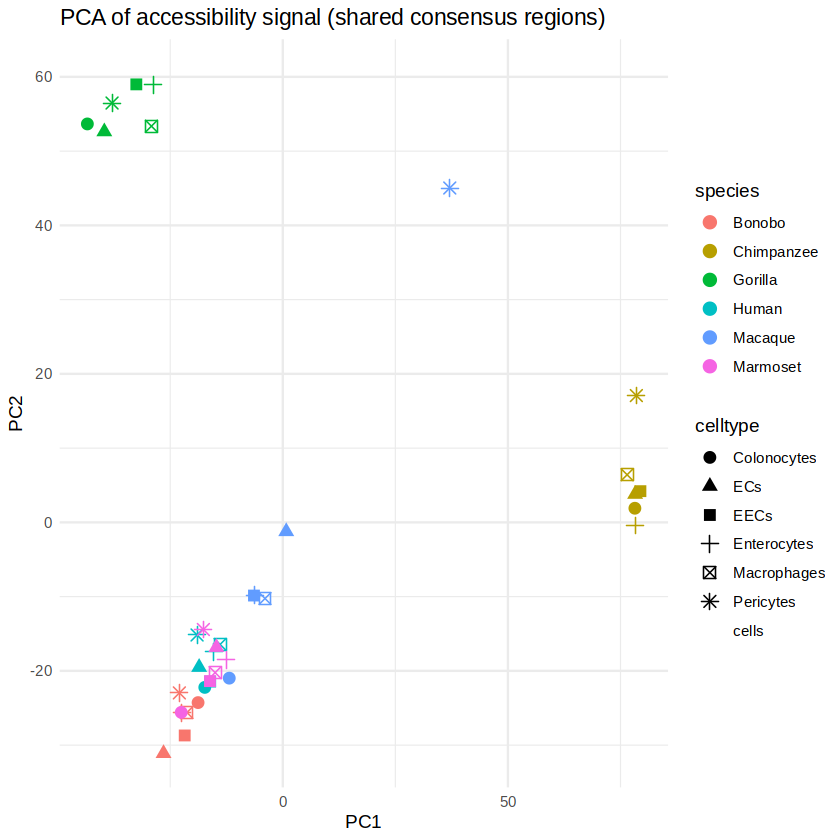

In [28]:
# === Step 4: Create colData ===
sample_names <- colnames(all_data)
coldata <- data.frame(
  sample = sample_names,
  species = sub("_.*", "", sample_names),
  celltype = sub(".*_", "", sample_names)
)
rownames(coldata) <- sample_names

# === Step 5: Build DESeq2 object ===
dds <- DESeqDataSetFromMatrix(
  countData = round(all_data),  # must be integers
  colData = coldata,
  design = ~ species + celltype
)

# === Step 6: Run DESeq2 and PCA ===
dds <- DESeq(dds)
vsd <- vst(dds)

# PCA plot
pcaData <- plotPCA(vsd, intgroup = c("species", "celltype"), returnData = TRUE)
ggplot(pcaData, aes(PC1, PC2, color = species, shape = celltype)) +
  geom_point(size = 3) +
  theme_minimal() +
  labs(title = "PCA of accessibility signal (shared consensus regions)")


In [30]:
library(DESeq2)
library(tidyverse)
library(ggplot2)
library(pheatmap)

# === Create output dir ===
out_dir <- "species_deseq2_results"
dir.create(out_dir, showWarnings = FALSE)

# === Load BED coordinates with region IDs ===
bed_coords <- read_tsv("master/shared_consensus_with_ids.hg38.bed",
                       col_names = c("chr", "start", "end", "region_id"))

# === Species to compare against Human ===
species_to_compare <- c("Chimpanzee", "Bonobo", "Gorilla", "Macaque", "Marmoset")

# === Loop over species ===
for (sp in species_to_compare) {
  message("🧬 Running DESeq2: Human vs ", sp)

  # Subset and prepare
  dds_subset <- dds[, dds$species %in% c("Human", sp)]
  dds_subset$species <- droplevels(dds_subset$species)
  design(dds_subset) <- ~ species

  # Run DESeq2
  dds_subset <- DESeq(dds_subset, quiet = TRUE)

  # Get results
  res <- results(dds_subset, contrast = c("species", "Human", sp)) %>%
    as.data.frame() %>%
    rownames_to_column("region_id")

  # Save full result table
  write_tsv(res, file.path(out_dir, paste0("DESeq2_Human_vs_", sp, "_AllCelltypes.tsv")))

  # Filter significant (padj < 0.05)
  sig_peaks <- res %>%
    filter(!is.na(padj) & padj < 0.05)

  # Join with coordinates
  sig_with_coords <- left_join(sig_peaks, bed_coords, by = "region_id")

  # === BASIC BEDs ===
  human_basic <- sig_with_coords %>%
    filter(log2FoldChange > 0) %>%
    select(chr, start, end)
  sp_basic <- sig_with_coords %>%
    filter(log2FoldChange < 0) %>%
    select(chr, start, end)

  write_tsv(human_basic, file.path(out_dir, paste0("DESeq2_Human_vs_", sp, "_HumanSpecific.bed")), col_names = FALSE)
  write_tsv(sp_basic, file.path(out_dir, paste0("DESeq2_Human_vs_", sp, "_", sp, "Specific.bed")), col_names = FALSE)

  # === STRONGER log2FC FILTERED BEDs (|log2FC| > 1) ===
  human_strong <- sig_with_coords %>%
    filter(log2FoldChange > 1) %>%
    select(chr, start, end)
  sp_strong <- sig_with_coords %>%
    filter(log2FoldChange < -1) %>%
    select(chr, start, end)

  write_tsv(human_strong, file.path(out_dir, paste0("DESeq2_Human_vs_", sp, "_HumanSpecific_logFC1.bed")), col_names = FALSE)
  write_tsv(sp_strong, file.path(out_dir, paste0("DESeq2_Human_vs_", sp, "_", sp, "Specific_logFC1.bed")), col_names = FALSE)

  message("✅ Done: ", sp, " | Sig: ", nrow(sig_peaks), 
          " | Human> ", nrow(human_basic), " (", nrow(human_strong), " >1)",
          " | ", sp, "> ", nrow(sp_basic), " (", nrow(sp_strong), " >1)")
}

Rows: 368636
Columns: 4
-- Column specifi
Delimiter: "\t"
chr (2): chr, region_id
dbl (2): start, end

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
<U+0001F9EC> Running DESeq2: Human vs Chimpanzee

<U+2705> Done: Chimpanzee | Sig: 914 | Human> 781 (774 >1) | Chimpanzee> 133 (132 >1)

<U+0001F9EC> Running DESeq2: Human vs Bonobo

<U+2705> Done: Bonobo | Sig: 15796 | Human> 230 (176 >1) | Bonobo> 15566 (15534 >1)

<U+0001F9EC> Running DESeq2: Human vs Gorilla

<U+2705> Done: Gorilla | Sig: 1711 | Human> 1167 (1146 >1) | Gorilla> 544 (539 >1)

<U+0001F9EC> Running DESeq2: Human vs Macaque

<U+2705> Done: Macaque | Sig: 456 | Human> 377 (377 >1) | Macaque> 79 (79 >1)

<U+0001F9EC> Running DESeq2: Human vs Marmoset

<U+2705> Done: Marmoset | Sig: 2412 | Human> 1452 (1423 >1) | Marmoset> 960 (940 >1)



In [41]:
library(ggplot2)
library(gtools)
library(readr)
library(dplyr)
library(ggrepel)
library(tidyverse)

plot_manhattan <- function(deseq_file, bed_file, chromsizes_file, output_file, plot_title = NULL, width = 16, height = 5) {
  # Load data
  deseq_res <- read_tsv(deseq_file, show_col_types = FALSE)
  bed_coords <- read_tsv(bed_file, col_names = c("chr", "start", "end", "region_id"), show_col_types = FALSE)
  chromsizes <- read_tsv(chromsizes_file, col_names = c("chr", "size"), show_col_types = FALSE)

  # Clean and order chromosomes
  chromsizes <- chromsizes %>%
    filter(chr %in% bed_coords$chr) %>%
    arrange(mixedorder(chr)) %>%
    mutate(offset = lag(cumsum(size), default = 0))  # Genomic offset for each chromosome

  # Join DESeq2 + BED
  plot_data <- left_join(deseq_res, bed_coords, by = "region_id") %>%
    filter(!is.na(chr)) %>%
    left_join(chromsizes, by = "chr") %>%
    mutate(genomic_pos = offset + (start + end) / 2)

  # X-axis labels at chromosome midpoints
  chr_ticks <- chromsizes %>%
    mutate(midpoint = offset + size / 2)

  # Default title
  if (is.null(plot_title)) {
    plot_title <- tools::file_path_sans_ext(basename(deseq_file))
  }

  # Plot
  p <- ggplot(plot_data, aes(x = genomic_pos, y = -log10(pvalue), color = chr)) +
    geom_point(size = 0.5, alpha = 0.8, show.legend = FALSE) +
    scale_color_manual(values = rep(c("#1f77b4", "#ff7f0e"), length.out = nrow(chr_ticks))) +
    scale_x_continuous(
      label = chr_ticks$chr,
      breaks = chr_ticks$midpoint,
      expand = expansion(mult = c(0.01, 0.01))
    ) +
    labs(
      x = "Chromosome",
      y = expression(-log[10](pvalue)),
      title = plot_title
    ) +
    theme_minimal(base_size = 14) +
    theme(
      axis.text.x = element_text(angle = 90, vjust = 0.5, size = 10),
      panel.grid.major.x = element_blank(),
      plot.title = element_text(hjust = 0.5)
    )

  ggsave(output_file, p, width = width, height = height)
  message("✅ Saved plot to ", output_file)
  return(p)
}

In [43]:
dir.create("plots", showWarnings = FALSE)

comparisons <- c("Human_vs_Bonobo", "Human_vs_Chimpanzee", "Human_vs_Gorilla", "Human_vs_Macaque", "Human_vs_Marmoset")

for (comp in comparisons) {
  deseq_file <- paste0("species_deseq2_results/DESeq2_", comp, "_AllCelltypes.tsv")
  output_file <- paste0("plots/Manhattan_", comp, ".pdf")



    plot_manhattan(
      deseq_file = deseq_file,
      bed_file = "master/shared_consensus_with_ids.hg38.bed",
      chromsizes_file = "~/jjans/analysis/cerebellum/genomes_new/homo_sapiens/hg38.chrom.sizes",
      output_file = output_file
    )

}

Warning message:
"Removed 74 rows containing missing values (geom_point)."
<U+2705> Saved plot to plots/Manhattan_Human_vs_Bonobo.pdf

Warning message:
"Removed 76 rows containing missing values (geom_point)."
<U+2705> Saved plot to plots/Manhattan_Human_vs_Chimpanzee.pdf

Warning message:
"Removed 69 rows containing missing values (geom_point)."
<U+2705> Saved plot to plots/Manhattan_Human_vs_Gorilla.pdf

Warning message:
"Removed 62 rows containing missing values (geom_point)."
<U+2705> Saved plot to plots/Manhattan_Human_vs_Macaque.pdf

Warning message:
"Removed 86 rows containing missing values (geom_point)."
<U+2705> Saved plot to plots/Manhattan_Human_vs_Marmoset.pdf



In [44]:
library(limma)

# Subset Enterocytes only
enterocyte_counts <- all_data[, endsWith(colnames(all_data), "_Enterocytes")]
enterocyte_counts <- enterocyte_counts[, c("Human_Enterocytes", "Bonobo_Enterocytes")]

# Design
group <- factor(c("Human", "Bonobo"))
design <- model.matrix(~group)

# voom normalization
v <- voom(enterocyte_counts, design, plot = TRUE)

# Fit linear model
fit <- lmFit(v, design)
fit <- eBayes(fit)

# Results
topTable(fit, coef = 2, n = Inf)


Attaching package: 'limma'


The following object is masked from 'package:DESeq2':

    plotMA


The following object is masked from 'package:BiocGenerics':

    plotMA


Warning message in voom(enterocyte_counts, design, plot = TRUE):
"The experimental design has no replication. Setting weights to 1."


ERROR: Error in .ebayes(fit = fit, proportion = proportion, stdev.coef.lim = stdev.coef.lim, : No residual degrees of freedom in linear model fits
